# PSYC 193: Perception and Computation 
## Lab 3: Higher-level feature representations and kNN classification

In this lab, we will continue working with an image dataset used in a recent computer vision paper by [Sangkloy et al.](https://dl.acm.org/doi/abs/10.1145/2897824.2925954). 

**Learning objectives**
* Higher-level feature representations of images
* Representational Dissimilarity Matrices

**Submission instructions**
1. Please rename the notebook by replacing `YOURUSERNAME` in the filename with your actual UCSD AD username. 
2. Before submitting your assignment, sure that your notebook can run from "top to bottom," executing the code in every code cell without returning fatal errors. An easy way to verify this is to click "Kernel" above in the tool bar, and try selecting "Restart & Run All."
3. Once you have verified that your notebook can run "top to bottom" without issues, click "File" in the toolbar above, then "Download as," then "PDF via LaTeX" to download a PDF version of your notebook. 
4. Upload this PDF version of your notebook to Canvas before 5pm the next class period. 

### setup

In [1]:
## load generally useful python modules
import os
import numpy as np
import pandas as pd
from PIL import Image
import requests
from io import BytesIO
import seaborn as sns

import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize, getfigs
%matplotlib inline
from IPython.display import clear_output

## load pytorch
import torch
import torch.nn as nn
from torchvision import models

### general params

In [2]:
data_dir = 'images'
feature_dir = 'features'

### load in dataset

In [3]:
## import image metadata (from Sangkloy et al. (2016))
from photodraw32_metadata import metadata
M = pd.DataFrame(metadata)

### load and display a sample image

Example Image URL: https://photodraw32.s3.amazonaws.com/n02691156_359_airplane_00.png


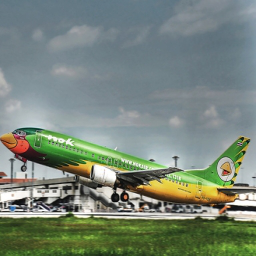

In [4]:
url = M['s3_url'].values[0] 
print('Example Image URL: {}'.format(url))
response = requests.get(url)
img1 = Image.open(BytesIO(response.content))
img1

### download all images

In [31]:
def download_im(url, out_dir = 'images'):
    '''
    input:
        url: str, image URL for single image
        out_dir: str, path to location where you want to save this image
    output:
        image saved to file
    '''
    ## extract filename from URL
    fname = url.split('/')[-1]
    
    if not os.path.exists(os.path.join(out_dir,fname)):

        ## get image data
        response = requests.get(url)    
        img = Image.open(BytesIO(response.content))

        ## create data_dir if it does not already exist
        ### INSERT YOUR CODE HERE ###
        if not os.path.exists(out_dir):
            os.mkdir(out_dir)
            
        ## save image here
        img.save(os.path.join(out_dir, fname))
                                   
        print('Saved image {} to {}'.format(fname, out_dir))
    else:
        
        print('Already have image {} saved, passing over.'.format(fname))
        
    return fname

In [32]:
## download images, passing over those we've already downloaded
for ind, url in enumerate(M['s3_url'].values): 
    x = download_im(url, out_dir = 'images')
    clear_output(wait=True)
print('Done!')

Done!


### extract image features

#### PIXELS

In [5]:
## rescale to this imsize
imsize = 64
# 64 by 64 

## get list of paths 
im_paths = [os.path.join(data_dir, path) for path in M.s3_filename.values]

## init P pixel feature matrix
PF = np.zeros((M.shape[0], imsize*imsize))
num_pix_feats = PF.shape[1]

## create new column that corresponds to image_id column in VGG metadata
M['image_id'] = M.apply(lambda x: x['s3_filename'].split('.')[0], axis=1)

## iterate over image paths and add pixel feature representation to P feature matrix
for ind, path in enumerate(im_paths):
    im = Image.open(path)
    im_32 = im.resize((imsize, imsize), Image.ANTIALIAS)
    im_gray = im_32.convert("L")
    im_arr = np.array(im_gray).astype(np.float64)
    vec = im_arr.flatten()
    PF[ind,:] = vec
    print('Extracting pixel feature representation for {}'.format(path))
    clear_output(wait=True)
    
## join pixel feature matrix and metadata to form single PIXEL dataframe
P = M.join(pd.DataFrame(PF, M.index))



Extracting pixel feature representation for images/n04587648_16394_window_31.png


#### VGG19 "fc6" features

In [6]:
## pre-extracted, only extract if you wish to overwrite
extract=False
if extract:
    cmd_string = "python extract_features.py --data={} --out_dir={}".format(data_dir,feature_dir)
    os.system(cmd_string)
    
## load in feature matrix and apply preprocessing (channel-wise normalization)
from extract_features import normalize
VF = normalize(np.load('features/FEATURES_FC6_IMAGES.npy'))
num_vgg_feats = VF.shape[1]

## load in metadata corresponding to VGG features
VM = pd.read_csv('features/METADATA_images.csv')    

## join feature matrix and metadata to form single VGG dataframe
V = VM.join(pd.DataFrame(VF))

In [7]:
## create new columns to make it easier to sort into categories alphabetically
V['category'] = V.apply(lambda x: x['image_id'].split('_')[-2], axis=1)
V.loc[V['category']=='(sedan)', 'category'] = 'car_(sedan)' ## deal with exception, so categories sort properly

V['img_ind'] = VM.apply(lambda x: x['image_id'].split('_')[-1], axis=1)

## sort rows by category, then by img_ind
V.sort_values(by=['category','img_ind'], ascending=True, inplace=True)

### visualize dissimilarity between images

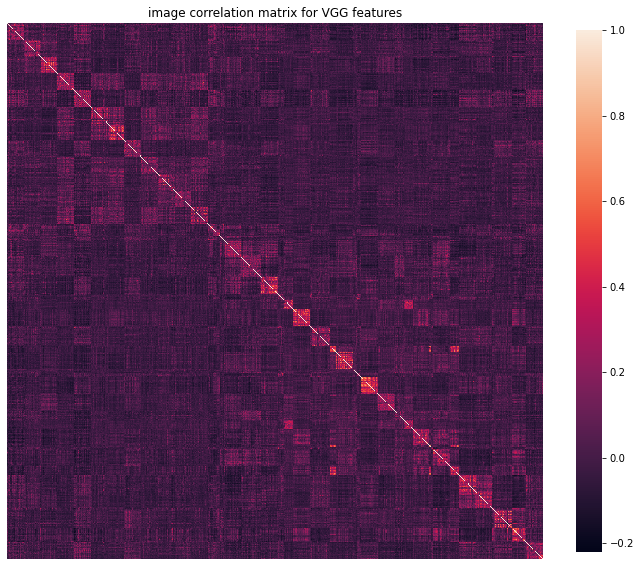

In [8]:
## visualize correlation matrix for VGG-19 representation of images
corrmat = np.corrcoef(VF)
plt.figure(figsize=(12,12))
sns.heatmap(corrmat, square=True, xticklabels='', yticklabels='', cbar_kws={'shrink':0.8})
t = plt.title('image correlation matrix for VGG features')

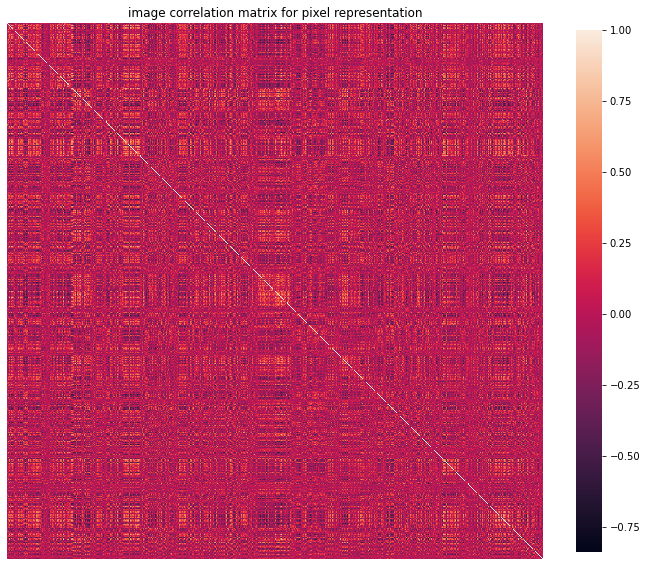

In [9]:
## visualize correlation matrix for pixel representation of images
plt.figure(figsize=(12,12))
corrmat = np.corrcoef(PF)
sns.heatmap(corrmat, square=True, xticklabels='', yticklabels='', cbar_kws={'shrink':0.8})
t = plt.title('image correlation matrix for pixel representation')

#### What differences do you notice between the two RDMs above?

_VGC features have a distinct (negative) correlation whereas the pixel representation is random._

### Category RDMs
Based on the 1024x1024 image-level RDM for the VGG features, derive a 32x32 category-level RDM, where each cell represents the correlation between mean feature vector for category1 and the mean feature vector for category2.

BONUS: Apply clustering over these mean feature vectors to find a way of ordering them that highlights similarities between categories.

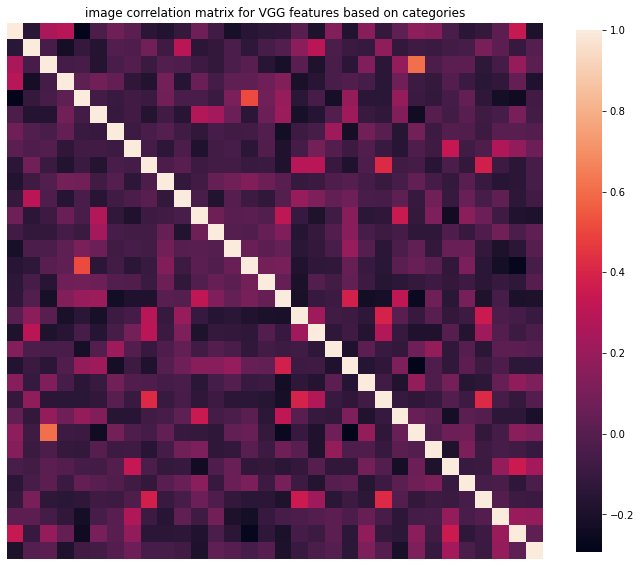

In [10]:
### INSERT YOUR CODE HERE ###

# calculating the mean feature vector for each category
V_avg = (V.groupby('category')).mean()
# dropping feature_ind column so dataframe only has numerical values
V_num = V_avg.drop('feature_ind', axis = 1)
# turning all column values into arrays for further calculation
Vlist = V_num.values
# using previous code to plot
plt.figure(figsize=(12,12))
corrmat = np.corrcoef(Vlist)
sns.heatmap(corrmat, square=True, xticklabels='', yticklabels='', cbar_kws={'shrink':0.8})
t = plt.title('image correlation matrix for VGG features based on categories')

### Visualize using t-SNE

t-SNE is a popular and useful visualization tool for examining structure in high-dimensional data. To learn more about t-SNE, check out this article from [Distill.pub](https://distill.pub/2016/misread-tsne/).

#### visualizing clusters of images using VGG features

In [11]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
_VF = PCA(n_components=50).fit_transform(VF)
__VF = TSNE(n_components=2).fit_transform(_VF)
VF_ = pd.DataFrame(__VF)
VF_.columns=['tsne_0', 'tsne_1']
V = V.join(VF_)

Text(0.5, 1.0, 't-SNE visualization of image clusters using VGG features')

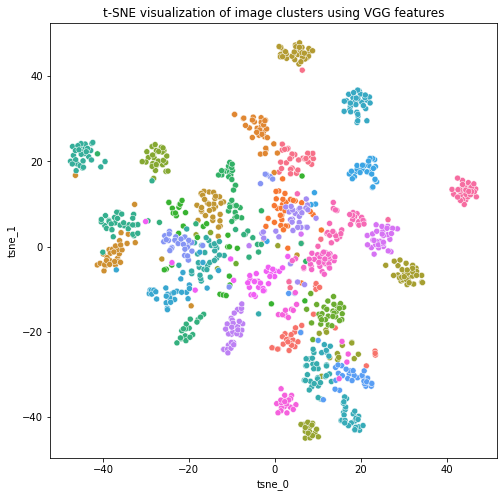

In [19]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=V, 
                x='tsne_0',
                y='tsne_1',
                hue='category',
                legend=False)
plt.title('t-SNE visualization of image clusters using VGG features')

#### visualizing clusters of images using pixel features

In [12]:
from sklearn.manifold import TSNE
_PF =PCA(n_components=50).fit_transform(PF)
__PF = TSNE(n_components=2).fit_transform(_PF)
PF_ = pd.DataFrame(__PF)
PF_.columns=['tsne_0', 'tsne_1']
P = P.join(PF_)

Text(0.5, 1.0, 't-SNE visualization of image clusters using pixel features')

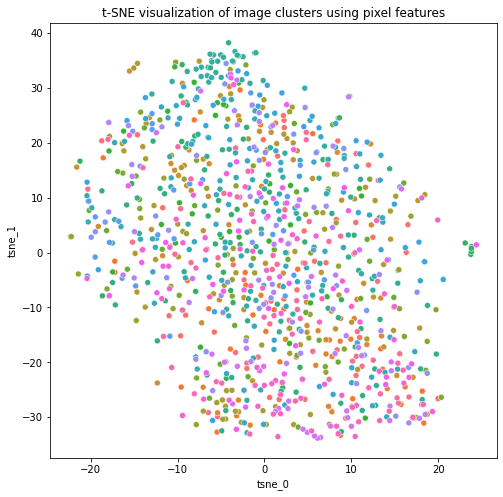

In [13]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=P, 
                x='tsne_0',
                y='tsne_1',
                hue='category',
                legend=False)
plt.title('t-SNE visualization of image clusters using pixel features')

#### What differences do you notice between the two scatterplots above?

_Insert your response here._

In [21]:
VF

array([[-0.69584715,  0.85113955, -0.33839613, ...,  1.1059273 ,
        -0.6630375 , -0.38443   ],
       [-0.674634  , -0.46294725, -0.33839613, ..., -0.47169358,
        -0.4143223 , -0.38443   ],
       [-0.28496718, -0.46294725, -0.33839613, ..., -0.47169358,
         2.4225094 , -0.38443   ],
       ...,
       [ 2.0839894 , -0.46294725, -0.33839613, ..., -0.15640813,
        -0.6630375 ,  1.3115596 ],
       [ 0.8870281 , -0.46294725, -0.33839613, ..., -0.47169358,
        -0.6630375 ,  0.8561988 ],
       [ 0.5577087 , -0.46294725, -0.33839613, ...,  0.8091041 ,
        -0.29969016,  1.8876268 ]], dtype=float32)

In [14]:
PF

array([[114., 114., 115., ..., 103., 104., 107.],
       [149., 131., 119., ..., 223., 215., 207.],
       [134., 134., 133., ..., 130., 130., 131.],
       ...,
       [ 87.,  88.,  89., ..., 108., 108., 109.],
       [142., 143., 144., ..., 133., 132., 132.],
       [ 79.,  71.,  61., ...,  88., 102., 128.]])